# font2img
- ttf 파일의 폰트를 가져와 이미지로 바꾸는 작업

In [1]:
import argparse
import sys
import glob
import numpy as np
import io, os
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import collections

In [2]:
SRC_PATH = './fonts/source/'
TRG_PATH = './fonts/target/'
OUTPUT_PATH = './dataset_png/'
PKLS_PATH = './dataset_pkl/'
SAVE_PATH = './save/'

In [3]:
def draw_single_char(ch, font, canvas_size):
    image = Image.new('L', (canvas_size, canvas_size), color = 255)
    drawing = ImageDraw.Draw(image)
    w, h = drawing.textsize(ch, font=font)
    drawing.text(
        ((canvas_size-w)/2, (canvas_size-h)/2),
        ch,
        fill=(0),
        font=font
    )
    flag = np.sum(np.array(image))
    
    #해당 font에 글자가 없으면 return None
    if flag == 255 * 128 * 128:
        return None
    
    return image

In [4]:
def draw_example(ch, src_font, dst_font, canvas_size):
    dst_img = draw_single_char(ch, dst_font, canvas_size)
    
    #해당 font에 글자가 없으면 return None
    if not dst_img:
        return None
    
    src_img = draw_single_char(ch, src_font, canvas_size)
    example_img = Image.new("RGB", (canvas_size*2,canvas_size), (255,255,255)).convert('L')
    example_img.paste(dst_img, (0,0))
    example_img.paste(src_img, (canvas_size,0))
    return example_img

In [5]:
def draw_handwriting(ch, src_font, canvas_size, dst_folder, label, count):
    dst_path = dst_folder + "%d_%04d" % (label, count) + ".png"
    dst_img = Image.open(dst_path)
    src_img = draw_single_char(ch, src_font, canvas_size)
    example_img = Image.new("RGB", (canvas_size * 2, canvas_size), (255, 255, 255)).convert('L')
    example_img.paste(dst_img, (0, 0))
    example_img.paste(src_img, (canvas_size, 0))
    return example_img


# Package
- img to pickle

In [6]:
from __future__ import print_function
from __future__ import absolute_import

import argparse
import glob
import os
import pickle as pickle
import random

In [7]:
def pickle_examples(from_dir, train_path, val_path, train_val_split=0.2, with_charid=False):
    """
    Compile a list of examples into pickled format, so during
    the training, all io will happen in memory
    """
    paths = glob.glob(os.path.join(from_dir, "*.png"))
    with open(train_path, 'wb') as ft:
        with open(val_path, 'wb') as fv:
            print('all data num:', len(paths))
            c = 1
            val_count = 0
            train_count = 0
            if with_charid:
                print('pickle with charid')
                for p in paths:
                    c += 1
                    label = int(os.path.basename(p).split("_")[0])#font
                    charid = int(os.path.basename(p).split("_")[1].split(".")[0])#가나다
                    with open(p, 'rb') as f:
                        img_bytes = f.read()
                        example = (label, charid, img_bytes)
                        r = random.random()
                        if r < train_val_split:
                            pickle.dump(example, fv)
                            val_count += 1
                            if val_count % 10000 == 0:
                                print("%d imgs saved in val.obj" % val_count)
                        else:
                            pickle.dump(example, ft)
                            train_count += 1
                            if train_count % 10000 == 0:
                                print("%d imgs saved in train.obj" % train_count)
                print("%d imgs saved in val.obj, end" % val_count)
                print("%d imgs saved in train.obj, end" % train_count)
            else:
                for p in paths:
                    c += 1
                    label = int(os.path.basename(p).split("_")[0])
                    with open(p, 'rb') as f:
                        img_bytes = f.read()
                        example = (label, img_bytes)
                        r = random.random()
                        if r < train_val_split:
                            pickle.dump(example, fv)
                            val_count += 1
                            if val_count % 10000 == 0:
                                print("%d imgs saved in val.obj" % val_count)
                        else:
                            pickle.dump(example, ft)
                            train_count += 1
                            if train_count % 10000 == 0:
                                print("%d imgs saved in train.obj" % train_count)
                print("%d imgs saved in val.obj, end" % val_count)
                print("%d imgs saved in train.obj, end" % train_count)
            return

In [8]:
def pickle_interpolation_data(from_dir, save_path, char_ids, font_filter):
    paths = glob.glob(os.path.join(from_dir, "*.png"))
    with open(save_path, 'wb') as ft:
        c = 0
        for p in paths:
            charid = int(p.split('/')[-1].split('.')[0].split('_')[1])
            label = int(os.path.basename(p).split("_")[0])
            if (charid in char_ids) and (label in font_filter):
                c += 1
                with open(p, 'rb') as f:
                    img_bytes = f.read()
                    example = (label, charid, img_bytes)
                    pickle.dump(example, ft)
        print('data num:', c)
        return

# Function
- deep learning functions : conv2d, relu etc.

In [9]:
from __future__ import print_function
from __future__ import absolute_import
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [10]:
def batch_norm(c_out, momentum=0.1):
    return nn.BatchNorm2d(c_out, momentum=momentum)

In [11]:
def conv2d(c_in, c_out, k_size, stride=2, pad=1, dilation=1, bn=True, lrelu=True, leak=0.2):
    layers =[]
    if lrelu:
        layers.append(nn.LeakyReLU(leak))
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [12]:
def deconv2d(c_in, c_out, k_size=3, stride=1, pad=1, dilation=1, bn=True, dropout=False, p=0.5):
    layers = []
    layers.append(nn.LeakyReLU(0.2))
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    if dropout:
        layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)

In [13]:
def lrelu(leak=0.2):
    return nn.LeakyReLU(leak).clone()

In [14]:
def dropout(p=0.2):
    return nn.Dropout(p)

In [15]:
def fc(input_size, output_size):
    return nn.Linear(input_size, output_size)

In [16]:
def init_embedding(embedding_num, embedding_dim, stddev=0.01):
    embedding = torch.randn(embedding_num, embedding_dim) * stddev
    embedding = embedding.reshape((embedding_num, 1, 1, embedding_dim))
    return embedding

In [17]:
def embedding_lookup(embeddings, embedding_ids, GPU=False):
    batch_size = len(embedding_ids)
    embedding_dim = embeddings.shape[3]
    local_embeddings = []
    for id_ in embedding_ids:
        if GPU:
            local_embeddings.append(embeddings[id_].cpu().numpy())
        else:
            local_embeddings.append(embeddings[id_].data.numpy())
    local_embeddings = torch.from_numpy(np.array(local_embeddings))
    if GPU:
        local_embeddings = local_embeddings.cuda()
    local_embeddings = local_embeddings.reshape(batch_size, embedding_dim, 1, 1)
    return local_embeddings

In [18]:
def interpolated_embedding_lookup(embeddings, interpolated_embedding_ids, grid):
    batch_size = len(interpolated_embedding_ids)
    interpolated_embeddings = []
    embedding_dim = embeddings.shape[3]

    for id_ in interpolated_embedding_ids:
        interpolated_embeddings.append((embeddings[id_[0]] * (1 - grid) + embeddings[id_[1]] * grid).cpu().numpy())
    interpolated_embeddings = torch.from_numpy(np.array(interpolated_embeddings)).cuda()
    interpolated_embeddings = interpolated_embeddings.reshape(batch_size, embedding_dim, 1, 1)
    return interpolated_embeddings

# Utils

- data pre-processing etc.

In [19]:
from __future__ import print_function
from __future__ import absolute_import

import os
import glob

import imageio
import scipy.misc as misc
import numpy as np
from io import BytesIO
from PIL import Image
#from scipy.misc import imresize
import matplotlib.pyplot as plt

In [20]:
def pad_seq(seq, batch_size):
    # pad the sequence to be the multiples of batch_size
    seq_len = len(seq)
    if seq_len % batch_size == 0:
        return seq
    padded = batch_size - (seq_len % batch_size)
    seq.extend(seq[:padded])
    return seq

In [21]:
def bytes_to_file(bytes_img):
    return BytesIO(bytes_img)

In [22]:
def normalize_image(img):
    """
    Make image zero centered and in between (-1, 1)
    """
    normalized = (img / 127.5) - 1.
    return normalized

In [23]:
def denorm_image(x):
    out = (x + 1) * 127.5
    return out.clamp(0, 255)

In [24]:
def read_split_image(img):
    #mat = misc.imread(img).astype(np.float)
    mat = imageio.imread(img).astype(np.float)
    side = int(mat.shape[1] / 2)
    assert side * 2 == mat.shape[1]
    img_A = mat[:, :side]  # target
    img_B = mat[:, side:]  # source

    return img_A, img_B

In [25]:
def shift_and_resize_image(img, shift_x, shift_y, nw, nh):
    w, h = img.shape
    #enlarged = misc.imresize(img, [nw, nh])
    enlarged = np.array(Image.fromarray(img).resize(size=(nh, nw)))
    return enlarged[shift_x:shift_x + w, shift_y:shift_y + h]

In [26]:
def scale_back(images):
    return (images + 1.) / 2.

In [27]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j * h:j * h + h, i * w:i * w + w, :] = image

    return img

In [28]:
def save_concat_images(imgs, img_path):
    concated = np.concatenate(imgs, axis=1)
    misc.imsave(img_path, concated)

In [29]:
def save_gif(gif_path, image_path, file_name):
    filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(os.path.join(gif_path, file_name), images)

In [30]:
def show_comparison(font_num, real_targets, fake_targets, show_num=8):
    plt.figure(figsize=(14, show_num//2+1))
    for idx in range(show_num):
        plt.subplot(show_num//4, 8, 2*idx+1)
        plt.imshow(real_targets[font_num][idx].reshape(128, 128), cmap='gray')
        plt.title("Real [%d]" % font_num)
        plt.axis('off')

        plt.subplot(show_num//4, 8, 2*idx+2)
        plt.imshow(fake_targets[font_num][idx].reshape(128, 128), cmap='gray')
        plt.title("Fake [%d]" % font_num)
        plt.axis('off')
    plt.show()

In [31]:
def tight_crop_image(img, verbose=False, resize_fix=False):
    img_size = img.shape[0]
    full_white = img_size
    col_sum = np.where(full_white - np.sum(img, axis=0) > 1)
    row_sum = np.where(full_white - np.sum(img, axis=1) > 1)
    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    cropped_image = img[y1:y2, x1:x2]
    cropped_image_size = cropped_image.shape
    
    if verbose:
        print('(left x1, top y1):', (x1, y1))
        print('(right x2, bottom y2):', (x2, y2))
        print('cropped_image size:', cropped_image_size)
        
    if type(resize_fix) == int:
        origin_h, origin_w = cropped_image.shape
        if origin_h > origin_w:
            resize_w = int(origin_w * (resize_fix / origin_h))
            resize_h = resize_fix
        else:
            resize_h = int(origin_h * (resize_fix / origin_w))
            resize_w = resize_fix
        
        # resize
        cropped_image = np.array(Image.fromarray(cropped_image).resize(size=(resize_h, resize_w)))
        cropped_image = normalize_image(cropped_image)
        cropped_image_size = cropped_image.shape
        if verbose:
            print('resized_image size:', cropped_image_size)
        
    elif type(resize_fix) == float:
        origin_h, origin_w = cropped_image.shape
        resize_h, resize_w = int(origin_h * resize_fix), int(origin_w * resize_fix)
        if resize_h > 120:
            resize_h = 120
            resize_w = int(resize_w * 120 / resize_h)
        if resize_w > 120:
            resize_w = 120
            resize_h = int(resize_h * 120 / resize_w)
        
        # resize
        cropped_image = Image.fromarray(cropped_image).resize(size=(resize_h, resize_w))
        cropped_image = normalize_image(cropped_image)
        cropped_image_size = cropped_image.shape
        if verbose:
            print('resized_image size:', cropped_image_size)
    
    return cropped_image

In [32]:
def add_padding(img, image_size=128, verbose=False, pad_value=None):
    height, width = img.shape
    if not pad_value:
        pad_value = img[0][0]
    if verbose:
        print('original cropped image size:', img.shape)
    
    # Adding padding of x axis - left, right
    pad_x_width = (image_size - width) // 2
    pad_x = np.full((height, pad_x_width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_x, img), axis=1)
    img = np.concatenate((img, pad_x), axis=1)
    
    width = img.shape[1]

    # Adding padding of y axis - top, bottom
    pad_y_height = (image_size - height) // 2
    pad_y = np.full((pad_y_height, width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_y, img), axis=0)
    img = np.concatenate((img, pad_y), axis=0)
    
    # Match to original image size
    width = img.shape[1]
    if img.shape[0] % 2:
        pad = np.full((1, width), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=0)
    height = img.shape[0]
    if img.shape[1] % 2:
        pad = np.full((height, 1), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=1)

    if verbose:
        print('final image size:', img.shape)
    
    return img

In [33]:
def centering_image(img, image_size=128, verbose=False, resize_fix=False, pad_value=None):
    if not pad_value:
        pad_value = 1
    cropped_image = tight_crop_image(img, verbose=verbose, resize_fix=resize_fix)
    centered_image = add_padding(cropped_image, image_size=image_size, verbose=verbose, pad_value=pad_value)
    
    return centered_image

In [34]:
def chars_to_ids(sentence):
    charset = []
    for i in range(0xac00,0xd7a4):
        charset.append(chr(i))

    fixed_char_ids = []
    for char in sentence:
        fixed_char_ids.append(charset.index(char))
        
    return fixed_char_ids

In [35]:
def round_function(i):
    if i < -0.95:
        return -1
    elif i > 0.95:
        return 1
    else:
        return i

# Dataset
- load dataset, data pre-processing

In [36]:
from __future__ import print_function
from __future__ import absolute_import
import pickle as pickle
import numpy as np
import random
import os
import torch

In [37]:
def get_batch_iter(examples, batch_size, augment, with_charid=False):
    # the transpose ops requires deterministic
    # batch size, thus comes the padding
    padded = pad_seq(examples, batch_size)

    def process(img):
        img = bytes_to_file(img)
        try:
            img_A, img_B = read_split_image(img)
            if augment:
                # augment the image by:
                # 1) enlarge the image
                # 2) random crop the image back to its original size
                # NOTE: image A and B needs to be in sync as how much
                # to be shifted
                w, h = img_A.shape
                multiplier = random.uniform(1.00, 1.20)
                # add an eps to prevent cropping issue
                nw = int(multiplier * w) + 1
                nh = int(multiplier * h) + 1
                shift_x = int(np.ceil(np.random.uniform(0.01, nw - w)))
                shift_y = int(np.ceil(np.random.uniform(0.01, nh - h)))
                img_A = shift_and_resize_image(img_A, shift_x, shift_y, nw, nh)
                img_B = shift_and_resize_image(img_B, shift_x, shift_y, nw, nh)
            img_A = normalize_image(img_A)
            img_A = img_A.reshape(1, len(img_A), len(img_A[0]))
            img_B = normalize_image(img_B)
            img_B = img_B.reshape(1, len(img_B), len(img_B[0]))
            return np.concatenate([img_A, img_B], axis=0)
        finally:
            img.close()
            
    def batch_iter(with_charid=with_charid):
        for i in range(0, len(padded), batch_size):
            batch = padded[i: i + batch_size]
            labels = [e[0] for e in batch]
            if with_charid:
                charid = [e[1] for e in batch]
                image = [process(e[2]) for e in batch]
                image = np.array(image).astype(np.float32)
                image = torch.from_numpy(image)
                # stack into tensor
                yield [labels, charid, image]
            else:
                image = [process(e[1]) for e in batch]
                image = np.array(image).astype(np.float32)
                image = torch.from_numpy(image)
                # stack into tensor
                yield [labels, image]

    return batch_iter(with_charid=with_charid)

In [38]:
#check _EOFERROR

class PickledImageProvider(object):
    def __init__(self, obj_path, verbose):
        self.obj_path = obj_path
        self.verbose = verbose
        self.examples = self.load_pickled_examples()

    def load_pickled_examples(self):
        with open(self.obj_path, "rb") as of:
            examples = list()
            while True:
                try:
                    e = pickle.load(of)
                    examples.append(e)
                except EOFError:
                    break
                except Exception:
                    pass
            if self.verbose:
                print("unpickled total %d examples" % len(examples))
            return examples

In [39]:
class TrainDataProvider(object):
    def __init__(self, data_dir, train_name="train.obj", val_name="val.obj", \
                 filter_by_font=None, filter_by_charid=None, verbose=True, val=True):
        self.data_dir = data_dir
        self.filter_by_font = filter_by_font
        self.filter_by_charid = filter_by_charid
        self.train_path = os.path.join(self.data_dir, train_name)
        self.val_path = os.path.join(self.data_dir, val_name)
        self.train = PickledImageProvider(self.train_path, verbose)
        if val:
            self.val = PickledImageProvider(self.val_path, verbose)
        if self.filter_by_font:
            if verbose:
                print("filter by label ->", filter_by_font)
            self.train.examples = [e for e in self.train.examples if e[0] in self.filter_by_font]
            if val:
                self.val.examples = [e for e in self.val.examples if e[0] in self.filter_by_font]
        if self.filter_by_charid:
            if verbose:
                print("filter by char ->", filter_by_charid)
            self.train.examples = [e for e in self.train.examples if e[1] in filter_by_charid]
            if val:
                self.val.examples = [e for e in self.val.examples if e[1] in filter_by_charid]
        if verbose:
            if val:
                print("train examples -> %d, val examples -> %d" % (len(self.train.examples), len(self.val.examples)))
            else:
                print("train examples -> %d" % (len(self.train.examples)))

                
    def get_train_iter(self, batch_size, shuffle=True, with_charid=False):
        training_examples = self.train.examples[:]
        if shuffle:
            np.random.shuffle(training_examples)
           
        if with_charid:
            return get_batch_iter(training_examples, batch_size, augment=True, with_charid=True)
        else:
            return get_batch_iter(training_examples, batch_size, augment=True)

        
    def get_val_iter(self, batch_size, shuffle=True, with_charid=False):
        """
        Validation iterator runs forever
        """
        val_examples = self.val.examples[:]
        if shuffle:
            np.random.shuffle(val_examples)
        if with_charid:
            return get_batch_iter(val_examples, batch_size, augment=True, with_charid=True)
        else:
            return get_batch_iter(val_examples, batch_size, augment=True)

        
    def compute_total_batch_num(self, batch_size):
        """Total padded batch num"""
        return int(np.ceil(len(self.train.examples) / float(batch_size)))

    
    def get_all_labels(self):
        """Get all training labels"""
        return list({e[0] for e in self.train.examples})

    
    def get_train_val_path(self):
        return self.train_path, self.val_path



In [40]:
def save_fixed_sample(sample_size, img_size, data_dir, save_dir, \
                      val=False, verbose=True, with_charid=True, resize_fix=90):
    data_provider = TrainDataProvider(data_dir, verbose=verbose, val=val)
    if not val:
        train_batch_iter = data_provider.get_train_iter(sample_size, with_charid=with_charid)
        print("going well -> train_batch_iter")
    else:
        train_batch_iter = data_provider.get_val_iter(sample_size, with_charid=with_charid)
        
    for batch in train_batch_iter:
        if with_charid:
            font_ids, _, batch_images = batch
        else:
            font_ids, batch_images = batch
            print("going well -> get batch")
        fixed_batch = batch_images.cuda()
        fixed_source = fixed_batch[:, 1, :, :].reshape(sample_size, 1, img_size, img_size)
        fixed_target = fixed_batch[:, 0, :, :].reshape(sample_size, 1, img_size, img_size)
        print("going well -> before centering")

        # centering
        for idx, (image_S, image_T) in enumerate(zip(fixed_source, fixed_target)):
            image_S = image_S.cpu().detach().numpy().reshape(img_size, img_size)
            image_S = np.array(list(map(round_function, image_S.flatten()))).reshape(128, 128)
            image_S = centering_image(image_S, resize_fix=90)
            fixed_source[idx] = torch.tensor(image_S).view([1, img_size, img_size])
            image_T = image_T.cpu().detach().numpy().reshape(img_size, img_size)
            image_T = np.array(list(map(round_function, image_T.flatten()))).reshape(128, 128)
            image_T = centering_image(image_T, resize_fix=resize_fix)
            fixed_target[idx] = torch.tensor(image_T).view([1, img_size, img_size])
        
        print("going well -> after centering")
        fixed_label = np.array(font_ids)
        source_with_label = [(label, image_S.cpu().detach().numpy()) \
                             for label, image_S in zip(fixed_label, fixed_source)]
        source_with_label = sorted(source_with_label, key=lambda i: i[0])
        target_with_label = [(label, image_T.cpu().detach().numpy()) \
                             for label, image_T in zip(fixed_label, fixed_target)]
        target_with_label = sorted(target_with_label, key=lambda i: i[0])
        fixed_source = torch.tensor(np.array([i[1] for i in source_with_label])).cuda()
        fixed_target = torch.tensor(np.array([i[1] for i in target_with_label])).cuda()
        fixed_label = sorted(fixed_label)
        print("going well -> before save torch")
        torch.save(fixed_source, os.path.join(save_dir, 'fixed_source.pkl'))
        print(1)
        torch.save(fixed_target, os.path.join(save_dir, 'fixed_target.pkl'))
        print(1)
        torch.save(fixed_label, os.path.join(save_dir, 'fixed_label.pkl'))
        print(1)
        return

# Models
- Generator(Encoder, Decoder), Discriminator

In [41]:
import torch
import torch.nn as nn
#from function import conv2d, deconv2d, lrelu, fc, embedding_lookup # .function 수정함
import warnings
warnings.filterwarnings("ignore")

In [42]:
def Generator(images, En, De, embeddings, embedding_ids, GPU=False, encode_layers=False):
    encoded_source, encode_layers = En(images)
    local_embeddings = embedding_lookup(embeddings, embedding_ids, GPU=GPU)
    if GPU:
        encoded_source = encoded_source.cuda()
        local_embeddings = local_embeddings.cuda()
    embedded = torch.cat((encoded_source, local_embeddings), 1)
    # print(embedded.shape, local_embeddings.shape)
    fake_target = De(embedded, encode_layers)
    if encode_layers:
        return fake_target, encoded_source, encode_layers
    else:
        return fake_target, encoded_source

In [43]:
class Encoder(nn.Module):
    
    def __init__(self, img_dim=1, conv_dim=64):
        super(Encoder, self).__init__()
        self.conv1 = conv2d(img_dim, conv_dim, k_size=5, stride=2, pad=2, dilation=2, lrelu=False, bn=False)
        self.conv2 = conv2d(conv_dim, conv_dim*2, k_size=5, stride=2, pad=2, dilation=2)
        self.conv3 = conv2d(conv_dim*2, conv_dim*4, k_size=4, stride=2, pad=1, dilation=1)
        self.conv4 = conv2d(conv_dim*4, conv_dim*8, k_size=3)
        self.conv5 = conv2d(conv_dim*8, conv_dim*8, k_size=3)
        self.conv6 = conv2d(conv_dim*8, conv_dim*8, k_size=3)
        self.conv7 = conv2d(conv_dim*8, conv_dim*8, k_size=3)
        self.conv8 = conv2d(conv_dim*8, conv_dim*8, k_size=3)

    def forward(self, images):
        encode_layers = dict()
        
        e1 = self.conv1(images)
        encode_layers['e1'] = e1
        e2 = self.conv2(e1)
        encode_layers['e2'] = e2
        e3 = self.conv3(e2)
        encode_layers['e3'] = e3
        e4 = self.conv4(e3)
        encode_layers['e4'] = e4
        e5 = self.conv5(e4)
        encode_layers['e5'] = e5
        e6 = self.conv6(e5)
        encode_layers['e6'] = e6
        e7 = self.conv7(e6)
        encode_layers['e7'] = e7
        encoded_source = self.conv8(e7)
        encode_layers['e8'] = encoded_source
        
        return encoded_source, encode_layers

In [44]:
class Decoder(nn.Module):
    
    def __init__(self, img_dim=1, embedded_dim=516, conv_dim=64):
        super(Decoder, self).__init__()
        self.deconv1 = deconv2d(embedded_dim, conv_dim*8, dropout=True)
        self.deconv2 = deconv2d(conv_dim*16, conv_dim*8, dropout=True, k_size=4)
        self.deconv3 = deconv2d(conv_dim*16, conv_dim*8, k_size=5, dilation=2, dropout=True)
        self.deconv4 = deconv2d(conv_dim*16, conv_dim*8, k_size=4, dilation=2, stride=2)
        self.deconv5 = deconv2d(conv_dim*16, conv_dim*4, k_size=4, dilation=2, stride=2)
        self.deconv6 = deconv2d(conv_dim*8, conv_dim*2, k_size=4, dilation=2, stride=2)
        self.deconv7 = deconv2d(conv_dim*4, conv_dim*1, k_size=4, dilation=2, stride=2)
        self.deconv8 = deconv2d(conv_dim*2, img_dim, k_size=4, dilation=2, stride=2, bn=False)
          
    
    def forward(self, embedded, encode_layers):
        
        d1 = self.deconv1(embedded.detach())
        d1 = torch.cat((d1, encode_layers['e7']), dim=1)
        d2 = self.deconv2(d1)
        d2 = torch.cat((d2, encode_layers['e6']), dim=1)
        d3 = self.deconv3(d2)
        d3 = torch.cat((d3, encode_layers['e5']), dim=1)
        d4 = self.deconv4(d3)
        d4 = torch.cat((d4, encode_layers['e4']), dim=1)
        d5 = self.deconv5(d4)
        d5 = torch.cat((d5, encode_layers['e3']), dim=1)
        d6 = self.deconv6(d5)
        d6 = torch.cat((d6, encode_layers['e2']), dim=1)
        d7 = self.deconv7(d6)
        d7 = torch.cat((d7, encode_layers['e1']), dim=1)
        d8 = self.deconv8(d7)        
        fake_target = torch.tanh(d8)
        
        return fake_target

In [45]:
class Discriminator(nn.Module):
    def __init__(self, category_num, img_dim=2, disc_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv2d(img_dim, disc_dim, k_size=3, bn=False)
        self.conv2 = conv2d(disc_dim, disc_dim*2, k_size=3)
        self.conv3 = conv2d(disc_dim*2, disc_dim*4, k_size=3)
        self.conv4 = conv2d(disc_dim*4, disc_dim*8, k_size=3)
        self.fc1 = fc(disc_dim*8*8*8, 1)
        self.fc2 = fc(disc_dim*8*8*8, category_num)
        self.flatten = nn.Flatten()

    def forward(self, images):
        batch_size = images.shape[0]
        h1 = self.conv1(images)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)
        h4 = self.conv4(h3)
       
        tf_loss_logit = self.fc1(h4.reshape(batch_size, -1))
        tf_loss = torch.sigmoid(tf_loss_logit)
        cat_loss = self.fc2(h4.reshape(batch_size, -1))
        
        return tf_loss, tf_loss_logit, cat_loss

# Train
- model Trainer

In [46]:
import os, glob, time, datetime
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torchvision.utils import save_image

In [47]:
class Trainer:
    
    def __init__(self, GPU, data_dir, fixed_dir, fonts_num, batch_size, img_size):
        self.GPU = GPU
        self.data_dir = data_dir
        self.fixed_dir = fixed_dir
        self.fonts_num = fonts_num
        self.batch_size = batch_size
        self.img_size = img_size
        
        self.embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
        #self.embeddings = embeddings
        self.embedding_num = self.embeddings.shape[0]
        self.embedding_dim = self.embeddings.shape[3]
        
        self.fixed_source = torch.load(os.path.join(fixed_dir, 'fixed_source.pkl'))
        self.fixed_target = torch.load(os.path.join(fixed_dir, 'fixed_target.pkl'))
        self.fixed_label = torch.load(os.path.join(fixed_dir, 'fixed_label.pkl'))
        
        self.data_provider = TrainDataProvider(self.data_dir)
        self.total_batches = self.data_provider.compute_total_batch_num(self.batch_size)
        print("total batches:", self.total_batches)


    def train(self, max_epoch, schedule, save_path, to_model_path, lr=0.001, \
              log_step=100, sample_step=350, fine_tune=False, flip_labels=False, \
              restore=None, from_model_path=False, with_charid=False, \
              freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90):

        # Fine Tuning coefficient
        if not fine_tune:
            L1_penalty, Lconst_penalty = 100, 15
        else:
            L1_penalty, Lconst_penalty = 500, 1000

        # Get Models
        En = Encoder()
        De = Decoder()
        D = Discriminator(category_num=self.fonts_num)
        if self.GPU:
            En.cuda()
            De.cuda()
            D.cuda()

        # Use pre-trained Model
        # restore에 [encoder_path, decoder_path, discriminator_path] 형태로 인자 넣기
        if restore:
            encoder_path, decoder_path, discriminator_path = restore
            prev_epoch = int(encoder_path.split('-')[0])
            En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
            De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
            D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
            print("%d epoch trained model has restored" % prev_epoch)
        else:
            prev_epoch = 0
            print("New model training start")


        # L1 loss, binary real/fake loss, category loss, constant loss
        if self.GPU:
            l1_criterion = nn.L1Loss(reduction='mean').cuda()#size_average=True).cuda()
            bce_criterion = nn.BCEWithLogitsLoss(reduction='mean').cuda()#(size_average=True).cuda()
            mse_criterion = nn.MSELoss(reduction='mean').cuda()#(size_average=True).cuda()
        else:
            l1_criterion = nn.L1Loss(size_average=True)
            bce_criterion = nn.BCEWithLogitsLoss(size_average=True)
            mse_criterion = nn.MSELoss(size_average=True)


        # optimizer
        if freeze_encoder:
            G_parameters = list(De.parameters())
        else:
            G_parameters = list(En.parameters()) + list(De.parameters())
        g_optimizer = torch.optim.Adam(G_parameters, lr=lr, betas=(0.5, 0.999))
        d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

        # losses lists
        l1_losses, const_losses, category_losses, d_losses, g_losses = list(), list(), list(), list(), list()

        # training
        count = 0
        for epoch in range(max_epoch):
            if (epoch + 1) % schedule == 0:
                updated_lr = max(lr/10, 0.00000000001)
                for param_group in d_optimizer.param_groups:
                    param_group['lr'] = updated_lr
                for param_group in g_optimizer.param_groups:
                    param_group['lr'] = updated_lr
                if lr !=  updated_lr:
                    print("decay learning rate from %.10f to %.10f" % (lr, updated_lr))
                lr = updated_lr

            train_batch_iter = self.data_provider.get_train_iter(self.batch_size, \
                                                            with_charid=with_charid)   
            for i, batch in enumerate(train_batch_iter):
                if with_charid:
                    font_ids, char_ids, batch_images = batch
                else:
                    font_ids, batch_images = batch
                embedding_ids = font_ids
                if self.GPU:
                    batch_images = batch_images.cuda()
                if flip_labels:
                    np.random.shuffle(embedding_ids)

                # target / source images
                real_target = batch_images[:, 0, :, :]
                real_target = real_target.view([self.batch_size, 1, self.img_size, self.img_size])
                real_source = batch_images[:, 1, :, :]
                real_source = real_source.view([self.batch_size, 1, self.img_size, self.img_size])
                
                # centering
                for idx, (image_S, image_T) in enumerate(zip(real_source, real_target)):
                    # trans = torchvision.transforms.ToPILImage()
                    # img = trans(image_T)
                    # img.save("see_img.jpg")
                    image_S = image_S.cpu().detach().numpy().reshape(self.img_size, self.img_size)
                    image_S = centering_image(image_S, resize_fix=90)
                    # trans = torchvision.transforms.ToPILImage()
                    # img = trans(torch.tensor(image_S).view([1, self.img_size, self.img_size]))
                    # img.save("see_img.jpg")
                    real_source[idx] = torch.tensor(image_S).view([1, self.img_size, self.img_size])
                    image_T = image_T.cpu().detach().numpy().reshape(self.img_size, self.img_size)
                    image_T = centering_image(image_T, resize_fix=resize_fix)
                    real_target[idx] = torch.tensor(image_T).view([1, self.img_size, self.img_size])

                # generate fake image form source image
                fake_target, encoded_source, _ = Generator(real_source, En, De, \
                                                           self.embeddings, embedding_ids, \
                                                           GPU=self.GPU, encode_layers=True)
          
                real_TS = torch.cat([real_source, real_target], dim=1)
                fake_TS = torch.cat([real_source, fake_target], dim=1)
                
                #discriminator scoring
                real_score, real_score_logit, real_cat_logit = D(real_TS)
                fake_score, fake_score_logit, fake_cat_logit = D(fake_TS)

                if self.GPU:
                    one_labels = torch.ones([self.batch_size, 1]).cuda()
                    zero_labels = torch.zeros([self.batch_size, 1]).cuda()
                else:
                    one_labels = torch.ones([self.batch_size, 1])
                    zero_labels = torch.zeros([self.batch_size, 1])

                real_binary_loss = bce_criterion(real_score_logit, one_labels)
                fake_binary_loss = bce_criterion(fake_score_logit, zero_labels)
                binary_loss = real_binary_loss + fake_binary_loss
                
                real_category = torch.from_numpy(np.eye(self.fonts_num)[embedding_ids]).float()
                if self.GPU:
                    real_category = real_category.cuda()
                real_category_loss = bce_criterion(real_cat_logit, real_category)
                fake_category_loss = bce_criterion(fake_cat_logit,real_category)
                category_loss = 0.5 * (real_category_loss + fake_category_loss)

                d_loss = binary_loss + category_loss

                D.zero_grad()
                d_loss.backward(retain_graph=True)
                d_optimizer.step()

                # generator scoring
                fake_score, fake_score_logit, fake_cat_logit = D(fake_TS.detach())
                

                # Get encoded fake image to calculate constant loss
                encoded_fake = En(fake_target)[0]
                const_loss = Lconst_penalty * mse_criterion(encoded_source, encoded_fake)

                # labels
                if self.GPU:
                    one_labels = torch.ones([self.batch_size, 1]).cuda()
                    zero_labels = torch.zeros([self.batch_size, 1]).cuda()
                else:
                    one_labels = torch.ones([self.batch_size, 1])
                    zero_labels = torch.zeros([self.batch_size, 1])

                real_category = torch.from_numpy(np.eye(self.fonts_num)[embedding_ids]).float()
                if self.GPU:
                    real_category = real_category.cuda()
                fake_category_loss = bce_criterion(fake_cat_logit,real_category)

                l1_loss = L1_penalty * l1_criterion(real_target, fake_target)

                cheat_loss = bce_criterion(fake_score_logit, one_labels)

                g_loss = cheat_loss + l1_loss + fake_category_loss + const_loss #cheat_loss + l1_loss + fake_category_loss + const_loss 

                En.zero_grad()
                De.zero_grad()
                g_loss.backward(retain_graph=True)
                g_optimizer.step() 

                # loss data
                l1_losses.append(int(l1_loss.data))
                const_losses.append(int(const_loss.data))
                category_losses.append(int(category_loss.data))
                d_losses.append(int(d_loss.data))
                g_losses.append(int(g_loss.data))

                # logging
                if (i+1) % log_step == 0:
                    time_ = time.time()
                    time_stamp = datetime.datetime.fromtimestamp(time_).strftime('%H:%M:%S')
                    log_format = 'Epoch [%d/%d], step [%d/%d], l1_loss: %.4f, d_loss: %.4f, g_loss: %.4f' % \
                                 (int(prev_epoch)+epoch+1, int(prev_epoch)+max_epoch, \
                                  i+1, self.total_batches, l1_loss.item(), d_loss.item(), g_loss.item())
                    print(time_stamp, log_format)

                # save image
                if (i+1) % sample_step == 0:
                    fixed_fake_images = Generator(self.fixed_target, En, De, \
                                                  self.embeddings, self.fixed_label, GPU=self.GPU)[0]
                    save_image(denorm_image(fixed_fake_images.data), \
                               os.path.join(save_path, 'fake_samples-%d-%d.png' % \
                                            (int(prev_epoch)+epoch+1, i+1)), \
                               nrow=save_nrow, pad_value=255)

            if not model_save_step:
                model_save_step = 5
            if (epoch+1) % model_save_step == 0:
                now = datetime.datetime.now()
                now_date = now.strftime("%m%d")
                now_time = now.strftime('%H:%M')
                torch.save(En.state_dict(), os.path.join(to_model_path, \
                                                         '%d-%s-%s-Encoder.pkl' % \
                                                         (int(prev_epoch)+epoch+1, \
                                                          now_date, now_time)))
                torch.save(De.state_dict(), os.path.join(to_model_path, \
                                                         '%d-%s-%s-Decoder.pkl' % \
                                                         (int(prev_epoch)+epoch+1, \
                                                          now_date, now_time)))
                torch.save(D.state_dict(), os.path.join(to_model_path, \
                                                        '%d-%s-%s-Discriminator.pkl' % \
                                                        (int(prev_epoch)+epoch+1, \
                                                         now_date, now_time)))
            
            gc.collect()
            torch.cuda.empty_cache()
            #decay_gauss_std(D)########################check it works

        # save model
        total_epoch = int(prev_epoch) + int(max_epoch)
        end = datetime.datetime.now()
        end_date = end.strftime("%m%d")
        end_time = end.strftime('%H:%M')
        torch.save(En.state_dict(), os.path.join(to_model_path, \
                                                 '%d-%s-%s-Encoder.pkl' % \
                                                 (total_epoch, end_date, end_time)))
        torch.save(De.state_dict(), os.path.join(to_model_path, \
                                                 '%d-%s-%s-Decoder.pkl' % \
                                                 (total_epoch, end_date, end_time)))
        torch.save(D.state_dict(), os.path.join(to_model_path, \
                                                '%d-%s-%s-Discriminator.pkl' % \
                                                (total_epoch, end_date, end_time)))
        losses = [l1_losses, const_losses, category_losses, d_losses, g_losses]
        torch.save(losses, os.path.join(to_model_path, '%d-losses.pkl' % total_epoch))

        return l1_losses, const_losses, category_losses, d_losses, g_losses

    def print_result(self,from_model_path,restore):
        En = Encoder()
        De = Decoder()
        D = Discriminator(category_num=self.fonts_num)
        if self.GPU:
            En.cuda()
            De.cuda()
            D.cuda()

        # Use pre-trained Model
        # restore에 [encoder_path, decoder_path, discriminator_path] 형태로 인자 넣기
        if restore:
            encoder_path, decoder_path, discriminator_path = restore
            prev_epoch = int(encoder_path.split('-')[0])
            En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
            De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
            D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
            #print("%d epoch trained model has restored" % prev_epoch)
        else:
            return None
        
        fixed_fake_images = Generator(self.fixed_target, En, De, \
                                      self.embeddings, self.fixed_label, GPU=self.GPU)[0]
        save_image(denorm_image(fixed_fake_images.data), \
                  os.path.join(save_path, 'show_fake-%d-%d.png' % \
                  (30,1002)), \
                  nrow=8, pad_value=255)
        
 


# Drive open

In [48]:
#in colab
from google.colab import drive
drive._mount('/content/drive')


Mounted at /content/drive


In [49]:
!pwd

/content


In [50]:
#in colab
%cd /content/drive/MyDrive/Capstone

/content/drive/MyDrive/Capstone


In [51]:
#cache 지우기
import torch,gc
gc.collect()
torch.cuda.empty_cache()

# embeddings 저장
main 파트 시작할때 임베딩 먼저 읽어와서 embeddings에 저장

In [ ]:
#다시 한번 수행하기
embeddings = init_embedding(11172, 4)
torch.save(embeddings,os.path.join(PKLS_PATH, 'EMBEDDINGS.pkl'))
temp_embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))

# 데이터 75000장 뽑아오기

In [ ]:
import random

train_chars = []
common_2350 = open("2350-common-hangul.txt", 'r', encoding = 'utf-8')

for i in range(2350):
    ch = common_2350.readline().replace('\n','')
    train_chars.append(chars_to_ids(ch)[0])

common_2350.close()

template_chars = []
real_char = open("template_target.txt",'r', encoding = 'utf-8')
for j in range(210):
    ch = real_char.readline().replace('\n','')
    template_chars.append(chars_to_ids(ch)[0])
  
real_char.close()



In [ ]:
font_lst = []
for i in range(20):
    rand_index = i
    font_lst.append(rand_index)
print(font_lst)
print(len(font_lst))

def get_train_chars():
    train_chars = []
    common_2350 = open("2350-common-hangul.txt", 'r', encoding = 'utf-8')

    for i in range(2000):
        ch = common_2350.readline().replace('\n','')
        train_chars.append(chars_to_ids(ch)[0])

    common_2350.close()
    
    return train_chars

In [ ]:
charset = []
for i in range(0xac00,0xd7a4):
    charset.append(chr(i))

In [ ]:
#### sample 생성
src_font = ImageFont.truetype(SRC_PATH + "source_font.ttf",100)
canvas_size = 128

for index in font_lst:
    ttf_index = str(index).zfill(2)
    ttf_name =ttf_index + ".ttf"
    dst_font = ImageFont.truetype(TRG_PATH + ttf_name ,100)
    train_chars = []
    train_chars = get_train_chars()
    for char_index in train_chars:
        ch = charset[char_index]
        made_img = draw_example(ch, src_font, dst_font, canvas_size)
        new_img_name = OUTPUT_PATH + ttf_index + "_" + str(char_index) + ".png"
        made_img.save(new_img_name, format='PNG')
    print("ok")
        


In [ ]:
train_path = OUTPUT_PATH + 'train.obj'
val_path = OUTPUT_PATH + 'val.obj'
pickle_examples(OUTPUT_PATH,train_path,val_path,0.2,True)

In [ ]:
!zip -r /content/drive/MyDrive/Capstone/dataset_png.zip /content/drive/MyDrive/Capstone/dataset_png/

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Capstone/dataset_png.zip')

#변수들


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/capstone/dataset_png.zip' -d .

In [ ]:
SRC_PATH = './fonts/source/'
TRG_PATH = './fonts/target/'
OUTPUT_PATH = './dataset_png/'
PKLS_PATH = './dataset_pkl/'
SAVE_PATH = './save_things_inML/pre_l1_const/'
FROM_PATH = './save_things_inML/pre_l1_const/models/'
MODEL_PATH = './save_things_inML/pre_l1_const/models/'
OBJ_PATH = OUTPUT_PATH

sample_size = 64 # tensor ver (original code) value & 위에 셀 참고
img_size = 128
data_dir = OUTPUT_PATH # .png 저장된 루트
save_dir = './dataset_pkl/'# .pkl 파일 루트

GPU = True #GPU 사용 여부
data_dir = OUTPUT_PATH # 학습 데이터 이미지 및 .obj가 저장된 곳
fixed_dir = PKLS_PATH # pickle data가 저장된 곳
fonts_num = 21
batch_size = 64 #tensor ver original code value
img_size = 128

max_epoch = 30
shcedule = 10
save_path = SAVE_PATH
to_model_path = MODEL_PATH

#Fixed Source file 생성 (Pre-training)


In [ ]:
#수정 (이거 test대비해 한번 더)
sample_size = 32
img_size = 128
data_dir = '/content/content/drive/MyDrive/Capstone/dataset_png'
save_dir = PKLS_PATH
save_fixed_sample(sample_size, img_size, data_dir, save_dir)

# Pre-training



## 1차 Pre-training

In [ ]:
GPU = True #GPU 사용 여부
data_dir = '/content/content/drive/MyDrive/Capstone/dataset_png/' #학습 데이터 이미지 및 .obj가 저장된 곳
fixed_dir = PKLS_PATH#pickle data가 저장된 곳
fonts_num = 40
batch_size = 64 #tensor ver original code value
img_size = 128

HandwritingFontML = Trainer(GPU, data_dir, fixed_dir, fonts_num, batch_size, img_size)

In [ ]:
max_epoch = 30
schedule = 10 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH

l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, sample_step=250, flip_labels=True, with_charid=True,freeze_encoder=False)

New model training start
14:55:09 Epoch [1/30], step [100/1002], l1_loss: 9.5623, d_loss: 0.5824, g_loss: 24.7383
14:56:06 Epoch [1/30], step [200/1002], l1_loss: 9.2983, d_loss: 0.5304, g_loss: 16.6256
14:57:01 Epoch [1/30], step [300/1002], l1_loss: 9.9129, d_loss: 0.2622, g_loss: 26.0318
14:57:55 Epoch [1/30], step [400/1002], l1_loss: 7.2225, d_loss: 0.3013, g_loss: 15.9269
14:58:48 Epoch [1/30], step [500/1002], l1_loss: 8.9792, d_loss: 0.2534, g_loss: 18.9875
14:59:41 Epoch [1/30], step [600/1002], l1_loss: 9.8760, d_loss: 1.0199, g_loss: 25.0480
15:00:34 Epoch [1/30], step [700/1002], l1_loss: 9.1952, d_loss: 0.3432, g_loss: 20.2606
15:01:28 Epoch [1/30], step [800/1002], l1_loss: 9.2669, d_loss: 0.3737, g_loss: 20.8805
15:02:21 Epoch [1/30], step [900/1002], l1_loss: 8.7973, d_loss: 0.3954, g_loss: 18.8906
15:03:14 Epoch [1/30], step [1000/1002], l1_loss: 8.5548, d_loss: 0.2933, g_loss: 21.5482
15:04:08 Epoch [2/30], step [100/1002], l1_loss: 7.3730, d_loss: 0.3158, g_loss: 20.

In [ ]:
max_epoch = 30
schedule = 5 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
in_restore = ["220-1219-22:00-Encoder.pkl","220-1219-22:00-Decoder.pkl","220-1219-22:00-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.0000001953, \
                                                                                      log_step=100, sample_step=250, fine_tune=False, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=FROM_PATH, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

220 epoch trained model has restored
decay learning rate from 0.0000001953 to 0.0000000977
22:27:06 Epoch [221/250], step [100/1002], l1_loss: 7.3406, d_loss: 0.1167, g_loss: 24.4962
22:28:03 Epoch [221/250], step [200/1002], l1_loss: 9.6614, d_loss: 0.1166, g_loss: 27.7674
22:29:00 Epoch [221/250], step [300/1002], l1_loss: 9.7800, d_loss: 0.1166, g_loss: 27.0880
22:29:56 Epoch [221/250], step [400/1002], l1_loss: 10.5179, d_loss: 0.1162, g_loss: 27.2458
22:30:53 Epoch [221/250], step [500/1002], l1_loss: 8.9257, d_loss: 0.1169, g_loss: 26.8647
22:31:49 Epoch [221/250], step [600/1002], l1_loss: 9.0906, d_loss: 0.1169, g_loss: 27.5467
22:32:46 Epoch [221/250], step [700/1002], l1_loss: 9.0122, d_loss: 0.1168, g_loss: 26.8554
22:33:43 Epoch [221/250], step [800/1002], l1_loss: 9.6891, d_loss: 0.1168, g_loss: 27.8379
22:34:39 Epoch [221/250], step [900/1002], l1_loss: 8.1146, d_loss: 0.1168, g_loss: 25.8298
22:35:36 Epoch [221/250], step [1000/1002], l1_loss: 8.2030, d_loss: 0.1169, g_l

In [ ]:
max_epoch = 50
schedule = 10 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH

l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, sample_step=250, flip_labels=True, with_charid=True,freeze_encoder=False)

New model training start
15:39:14 Epoch [1/50], step [100/719], l1_loss: 5.0871, d_loss: 0.7072, g_loss: 17.7416
15:40:10 Epoch [1/50], step [200/719], l1_loss: 6.7019, d_loss: 0.4458, g_loss: 22.5417
15:41:07 Epoch [1/50], step [300/719], l1_loss: 7.3903, d_loss: 0.4933, g_loss: 25.3812
15:42:04 Epoch [1/50], step [400/719], l1_loss: 6.7979, d_loss: 0.3805, g_loss: 19.3405
15:43:01 Epoch [1/50], step [500/719], l1_loss: 8.1066, d_loss: 0.3959, g_loss: 33.0135
15:43:58 Epoch [1/50], step [600/719], l1_loss: 5.8550, d_loss: 0.4473, g_loss: 17.9231
15:44:54 Epoch [1/50], step [700/719], l1_loss: 7.8762, d_loss: 0.3217, g_loss: 19.7357
15:46:02 Epoch [2/50], step [100/719], l1_loss: 7.8520, d_loss: 0.4392, g_loss: 38.8501
15:46:59 Epoch [2/50], step [200/719], l1_loss: 7.3232, d_loss: 0.4436, g_loss: 22.2244
15:47:56 Epoch [2/50], step [300/719], l1_loss: 6.3151, d_loss: 0.4530, g_loss: 27.7205
15:48:52 Epoch [2/50], step [400/719], l1_loss: 6.5216, d_loss: 0.4549, g_loss: 23.5634
15:49:4

In [ ]:
max_epoch = 30
schedule = 5 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
in_restore = ["50-1221-21:17-Encoder.pkl","50-1221-21:17-Decoder.pkl","50-1221-21:17-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.00003125, \
                                                                                      log_step=100, sample_step=250, fine_tune=False, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=FROM_PATH, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

50 epoch trained model has restored
12:33:43 Epoch [51/80], step [100/719], l1_loss: 6.3385, d_loss: 0.1885, g_loss: 20.3348
12:34:40 Epoch [51/80], step [200/719], l1_loss: 6.5113, d_loss: 0.1886, g_loss: 22.4292
12:35:38 Epoch [51/80], step [300/719], l1_loss: 6.6552, d_loss: 0.1892, g_loss: 22.3090
12:36:35 Epoch [51/80], step [400/719], l1_loss: 6.6968, d_loss: 0.1892, g_loss: 20.9342
12:37:32 Epoch [51/80], step [500/719], l1_loss: 5.1158, d_loss: 0.1887, g_loss: 20.0360
12:38:29 Epoch [51/80], step [600/719], l1_loss: 7.1960, d_loss: 0.1889, g_loss: 23.4258
12:39:26 Epoch [51/80], step [700/719], l1_loss: 7.0088, d_loss: 0.1891, g_loss: 22.4198
12:40:34 Epoch [52/80], step [100/719], l1_loss: 5.9986, d_loss: 0.1891, g_loss: 22.2107
12:41:30 Epoch [52/80], step [200/719], l1_loss: 8.5847, d_loss: 0.1886, g_loss: 24.3683
12:42:29 Epoch [52/80], step [300/719], l1_loss: 5.2848, d_loss: 0.1889, g_loss: 20.6844
12:43:25 Epoch [52/80], step [400/719], l1_loss: 6.6839, d_loss: 0.1892, g

In [ ]:
max_epoch = 20
schedule = 5 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
in_restore = ["80-1222-15:57-Encoder.pkl","80-1222-15:57-Decoder.pkl","80-1222-15:57-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.0000004883, \
                                                                                      log_step=100, sample_step=250, fine_tune=False, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=FROM_PATH, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

80 epoch trained model has restored
16:03:13 Epoch [81/100], step [100/719], l1_loss: 6.1346, d_loss: 0.1889, g_loss: 23.3780
16:04:09 Epoch [81/100], step [200/719], l1_loss: 6.0232, d_loss: 0.1890, g_loss: 22.6608
16:05:06 Epoch [81/100], step [300/719], l1_loss: 6.7431, d_loss: 0.1890, g_loss: 24.1437
16:06:03 Epoch [81/100], step [400/719], l1_loss: 5.9134, d_loss: 0.1893, g_loss: 22.0564
16:07:00 Epoch [81/100], step [500/719], l1_loss: 6.5037, d_loss: 0.1891, g_loss: 23.7239
16:07:57 Epoch [81/100], step [600/719], l1_loss: 8.5210, d_loss: 0.1889, g_loss: 26.0884
16:08:54 Epoch [81/100], step [700/719], l1_loss: 8.3708, d_loss: 0.1892, g_loss: 25.4236
16:10:02 Epoch [82/100], step [100/719], l1_loss: 7.0039, d_loss: 0.1890, g_loss: 23.7797
16:10:59 Epoch [82/100], step [200/719], l1_loss: 6.4654, d_loss: 0.1889, g_loss: 23.7365
16:11:56 Epoch [82/100], step [300/719], l1_loss: 6.6091, d_loss: 0.1891, g_loss: 23.8302
16:12:53 Epoch [82/100], step [400/719], l1_loss: 6.9729, d_loss

In [ ]:
max_epoch = 50
schedule = 5 
save_path = SAVE_PATH + 'models/else_models/models'
to_model_path = MODEL_PATH +'else_models/models/'
in_restore = ["100-1223-04:52-Encoder.pkl","100-1223-04:52-Decoder.pkl","100-1223-04:52-Discriminator.pkl"]
FROM_PATH_else = MODEL_PATH +'else_models/models/'
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, \
                                                                                      log_step=100, sample_step=250, fine_tune=False, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=FROM_PATH_else, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

100 epoch trained model has restored
04:40:48 Epoch [101/150], step [100/719], l1_loss: 32.0723, d_loss: 0.1910, g_loss: 43.8173
04:41:49 Epoch [101/150], step [200/719], l1_loss: 38.0827, d_loss: 0.1936, g_loss: 46.0458
04:42:49 Epoch [101/150], step [300/719], l1_loss: 40.1490, d_loss: 0.1892, g_loss: 52.9007
04:43:49 Epoch [101/150], step [400/719], l1_loss: 42.4951, d_loss: 0.1909, g_loss: 55.2638
04:44:49 Epoch [101/150], step [500/719], l1_loss: 37.8512, d_loss: 0.1899, g_loss: 51.2198
04:45:50 Epoch [101/150], step [600/719], l1_loss: 36.3696, d_loss: 0.1873, g_loss: 50.2956
04:46:50 Epoch [101/150], step [700/719], l1_loss: 40.8472, d_loss: 0.1883, g_loss: 54.6679
04:48:01 Epoch [102/150], step [100/719], l1_loss: 36.7440, d_loss: 0.1893, g_loss: 49.2895
04:49:02 Epoch [102/150], step [200/719], l1_loss: 42.6209, d_loss: 0.1912, g_loss: 54.7841
04:50:02 Epoch [102/150], step [300/719], l1_loss: 39.0028, d_loss: 0.1883, g_loss: 52.8496
04:51:02 Epoch [102/150], step [400/719], l

In [ ]:
max_epoch = 100
schedule = 5 #임의로
save_path = SAVE_PATH + 'models/else_models'
to_model_path = MODEL_PATH +'else_models/models/'
in_restore = ["150-1224-10:40-Encoder.pkl","150-1224-10:40-Decoder.pkl","150-1224-10:40-Discriminator.pkl"]
FROM_PATH_else = MODEL_PATH +'else_models/models/'
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, \
                                                                                      log_step=100, sample_step=250, fine_tune=False, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=FROM_PATH_else, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

150 epoch trained model has restored
11:01:10 Epoch [151/250], step [100/719], l1_loss: 30.6026, d_loss: 0.1901, g_loss: 45.4202
11:02:11 Epoch [151/250], step [200/719], l1_loss: 30.5693, d_loss: 0.1900, g_loss: 44.6536
11:03:12 Epoch [151/250], step [300/719], l1_loss: 33.6257, d_loss: 0.1894, g_loss: 47.1781
11:04:12 Epoch [151/250], step [400/719], l1_loss: 29.4929, d_loss: 0.1913, g_loss: 42.5370
11:05:13 Epoch [151/250], step [500/719], l1_loss: 36.1858, d_loss: 0.1904, g_loss: 49.3984
11:06:13 Epoch [151/250], step [600/719], l1_loss: 28.9937, d_loss: 0.1899, g_loss: 42.6588
11:07:13 Epoch [151/250], step [700/719], l1_loss: 42.1534, d_loss: 0.1890, g_loss: 56.4098
11:08:25 Epoch [152/250], step [100/719], l1_loss: 32.7093, d_loss: 0.1891, g_loss: 46.7781
11:09:26 Epoch [152/250], step [200/719], l1_loss: 32.4775, d_loss: 0.1893, g_loss: 46.2955
11:10:26 Epoch [152/250], step [300/719], l1_loss: 32.7772, d_loss: 0.1912, g_loss: 44.5085
11:11:26 Epoch [152/250], step [400/719], l

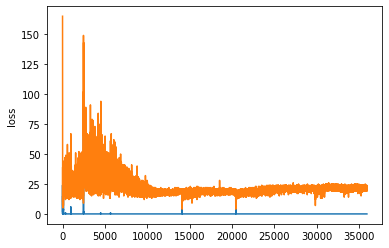

In [ ]:
import matplotlib.pyplot as plt
times = []
for i in range(len(d_losses)):
    times.append(i)
plt.plot(times, d_losses)
plt.plot(times, g_losses)


plt.ylabel('loss') 
plt.show()

##2차 Pre-training

In [ ]:
### 12/25토요일 저녁에 실행 시킬 것!!!!!!!
max_epoch = 100
schedule = 20 #임의로
save_path = SAVE_PATH + 'models/else_models'
to_model_path = MODEL_PATH +'else_models/models/'
in_restore = ["250-1224-23:03-Encoder.pkl","250-1224-23:03-Decoder.pkl","250-1224-23:03-Discriminator.pkl"]
FROM_PATH_else = MODEL_PATH +'else_models/models/'
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path,lr=0.00000002, \
                                                                                      log_step=100, sample_step=250, fine_tune=True, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=FROM_PATH_else, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

250 epoch trained model has restored
15:46:00 Epoch [251/350], step [100/719], l1_loss: 7.9794, d_loss: 0.1889, g_loss: 22.4434
15:46:57 Epoch [251/350], step [200/719], l1_loss: 6.7720, d_loss: 0.1889, g_loss: 22.3412
15:47:54 Epoch [251/350], step [300/719], l1_loss: 8.6600, d_loss: 0.1888, g_loss: 23.6278
15:48:51 Epoch [251/350], step [400/719], l1_loss: 6.3125, d_loss: 0.1891, g_loss: 22.0906
15:49:48 Epoch [251/350], step [500/719], l1_loss: 6.8668, d_loss: 0.1892, g_loss: 22.3730
15:50:45 Epoch [251/350], step [600/719], l1_loss: 9.3706, d_loss: 0.1883, g_loss: 24.9852
15:51:42 Epoch [251/350], step [700/719], l1_loss: 6.8203, d_loss: 0.1891, g_loss: 22.1943
15:52:50 Epoch [252/350], step [100/719], l1_loss: 8.3004, d_loss: 0.1887, g_loss: 23.5383
15:53:47 Epoch [252/350], step [200/719], l1_loss: 7.2371, d_loss: 0.1890, g_loss: 22.7415
15:54:44 Epoch [252/350], step [300/719], l1_loss: 7.5531, d_loss: 0.1889, g_loss: 22.8727
15:55:41 Epoch [252/350], step [400/719], l1_loss: 6.

In [ ]:
max_epoch = 500
schedule = 10 
save_path = SAVE_PATH
to_model_path = MODEL_PATH
from_model_path = '/content/drive/MyDrive/Capstone/save_things_inML/new_pre_only_l1/models/else_models/models'
in_restore = ["350-1226-03:07-Encoder.pkl","350-1226-03:07-Decoder.pkl","350-1226-03:07-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.0000000000001, \
                                                                                      log_step=100, sample_step=400, fine_tune=True, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=from_model_path, with_charid=True, \
                                                                                      freeze_encoder=False, save_nrow=8, model_save_step=None, resize_fix=90)

350 epoch trained model has restored
08:37:08 Epoch [351/850], step [100/719], l1_loss: 37.0440, d_loss: 0.1904, g_loss: 51.9017
08:38:05 Epoch [351/850], step [200/719], l1_loss: 31.2995, d_loss: 0.1903, g_loss: 44.5431
08:39:01 Epoch [351/850], step [300/719], l1_loss: 33.0022, d_loss: 0.1923, g_loss: 47.3575
08:39:58 Epoch [351/850], step [400/719], l1_loss: 35.0727, d_loss: 0.1899, g_loss: 49.9383
08:40:55 Epoch [351/850], step [500/719], l1_loss: 32.7803, d_loss: 0.1918, g_loss: 43.0392
08:41:51 Epoch [351/850], step [600/719], l1_loss: 34.9378, d_loss: 0.1939, g_loss: 49.4026
08:42:48 Epoch [351/850], step [700/719], l1_loss: 32.0765, d_loss: 0.1910, g_loss: 44.2132
08:43:56 Epoch [352/850], step [100/719], l1_loss: 39.1994, d_loss: 0.1894, g_loss: 50.0405
08:44:52 Epoch [352/850], step [200/719], l1_loss: 43.9048, d_loss: 0.1914, g_loss: 53.6942
08:45:48 Epoch [352/850], step [300/719], l1_loss: 36.6351, d_loss: 0.1901, g_loss: 50.7863
08:46:45 Epoch [352/850], step [400/719], l

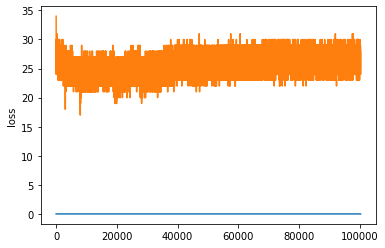

In [ ]:
import matplotlib.pyplot as plt
epoch_lst = []
for i in range(len(d_losses)):
    epoch_lst.append(i)
plt.plot(epoch_lst, d_losses)
plt.plot(epoch_lst, g_losses)

#plt.xlabel('epoch')
plt.ylabel('loss') #각 값에 대한 캡션이라고 보면 됨
plt.show()

# transfer learning

In [ ]:
#손글씨 학습 파라미터
SRC_PATH = './fonts/source/'
TRG_PATH = './fonts/target/'
OUTPUT_PATH = './dataset_png/'
PKLS_PATH = './dataset_pkl/'
SAVE_PATH = './save_things_inML/new_pre_only_l1/original_tl/'
FROM_PATH = './save_things_inML/new_pre_only_l1/models/'
MODEL_PATH = './save_things_inML/new_pre_only_l1/original_tl/models/'
OBJ_PATH = OUTPUT_PATH

sample_size = 64 #tensor ver (original code) value & 위에 셀 참고
img_size = 128
data_dir = OUTPUT_PATH #png 저장된 루트
save_dir = './dataset_pkl/'#pkl저장하는 파일 루트

GPU = True #GPU 사용 여부
data_dir = OUTPUT_PATH #학습 데이터 이미지 및 .obj가 저장된 곳
fixed_dir = PKLS_PATH#pickle data가 저장된 곳
fonts_num = 56
batch_size = 16 #tensor ver original code value
img_size = 128

fine_tune=True
freeze_encoder=True
#decoder는 새로 넣기

In [ ]:
#수정 (이거 test대비해 한번 더)
sample_size = 32
img_size = 128
data_dir = './dataset_hw/'#매번 바뀜/content/drive/MyDrive/Capstone/dataset_hw
save_dir = './dataset_pkl_transfer/'
save_fixed_sample(sample_size, img_size, data_dir, save_dir)

unpickled total 210 examples
train examples -> 210
going well -> train_batch_iter
going well -> before centering
going well -> after centering
going well -> before save torch
1
1
1


In [ ]:
GPU = True #GPU 사용 여부
data_dir = './dataset_hw/'#매번 바뀜
fixed_dir = './dataset_pkl_transfer/' #pickle data가 저장된 곳
fonts_num = 21
batch_size = 64 
img_size = 128

HandwritingFontML = Trainer(GPU, data_dir, fixed_dir, fonts_num, batch_size, img_size)

unpickled total 210 examples
unpickled total 0 examples
train examples -> 210, val examples -> 0
total batches: 4


In [ ]:
max_epoch = 1000
schedule = 20 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
from_model_path = '/content/drive/MyDrive/Capstone/save_things_inML/new_pre_only_l1/models'
in_restore = ["550-1230-07:23-Encoder.pkl","550-1230-07:23-Decoder.pkl","550-1230-07:23-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.0001, \
                                                                                      log_step=1, sample_step=3, fine_tune=False, flip_labels=False, \
                                                                                      restore=in_restore, from_model_path=from_model_path, with_charid=True, \
                                                                                      freeze_encoder=True, save_nrow=8, model_save_step=None, resize_fix=90)

In [ ]:
SAVE_PATH = './save_things_inML/new_pre_only_l1/new_tl_l1_const'
MODEL_PATH = './save_things_inML/new_pre_only_l1/new_tl_l1_const/models'

In [ ]:
max_epoch = 1000
schedule = 10 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
from_model_path = MODEL_PATH
in_restore = ["1495-1231-04:26-Encoder.pkl","1495-1231-04:26-Decoder.pkl","1495-1231-04:26-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.00000001, \
                                                                                      log_step=1, sample_step=3, fine_tune=True, flip_labels=False, \
                                                                                      restore=in_restore, from_model_path=from_model_path, with_charid=True, \
                                                                                      freeze_encoder=True, save_nrow=8, model_save_step=None, resize_fix=90)

1495 epoch trained model has restored
04:38:27 Epoch [1496/2495], step [1/4], l1_loss: 110.4635, d_loss: 0.9838, g_loss: 133.8525
04:38:27 Epoch [1496/2495], step [2/4], l1_loss: 113.8466, d_loss: 0.9800, g_loss: 136.7291
04:38:28 Epoch [1496/2495], step [3/4], l1_loss: 108.9435, d_loss: 0.9855, g_loss: 131.6863
04:38:29 Epoch [1496/2495], step [4/4], l1_loss: 115.2595, d_loss: 0.9798, g_loss: 138.1910
04:38:29 Epoch [1497/2495], step [1/4], l1_loss: 107.2457, d_loss: 0.9869, g_loss: 130.6360
04:38:30 Epoch [1497/2495], step [2/4], l1_loss: 111.6347, d_loss: 0.9841, g_loss: 134.6069
04:38:31 Epoch [1497/2495], step [3/4], l1_loss: 120.4453, d_loss: 0.9834, g_loss: 142.9538
04:38:31 Epoch [1497/2495], step [4/4], l1_loss: 100.4067, d_loss: 0.9794, g_loss: 123.6320
04:38:32 Epoch [1498/2495], step [1/4], l1_loss: 113.5267, d_loss: 0.9852, g_loss: 136.2271
04:38:33 Epoch [1498/2495], step [2/4], l1_loss: 98.0342, d_loss: 0.9832, g_loss: 121.3240
04:38:33 Epoch [1498/2495], step [3/4], l1_

In [ ]:
max_epoch = 300
schedule = 20 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
from_model_path = MODEL_PATH
in_restore = ["2495-1231-05:25-Encoder.pkl","2495-1231-05:25-Decoder.pkl","2495-1231-05:25-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.0000001, \
                                                                                      log_step=1, sample_step=3, fine_tune=True, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=from_model_path, with_charid=True, \
                                                                                      freeze_encoder=True, save_nrow=8, model_save_step=None, resize_fix=90)

2495 epoch trained model has restored
06:26:17 Epoch [2496/2795], step [1/4], l1_loss: 114.1252, d_loss: 0.9852, g_loss: 137.1137
06:26:17 Epoch [2496/2795], step [2/4], l1_loss: 109.2001, d_loss: 0.9856, g_loss: 131.6539
06:26:18 Epoch [2496/2795], step [3/4], l1_loss: 101.5103, d_loss: 0.9811, g_loss: 124.5598
06:26:19 Epoch [2496/2795], step [4/4], l1_loss: 107.8870, d_loss: 0.9870, g_loss: 130.9908
06:26:20 Epoch [2497/2795], step [1/4], l1_loss: 109.9407, d_loss: 0.9833, g_loss: 132.8938
06:26:21 Epoch [2497/2795], step [2/4], l1_loss: 101.6219, d_loss: 0.9857, g_loss: 124.7844
06:26:21 Epoch [2497/2795], step [3/4], l1_loss: 115.6365, d_loss: 0.9838, g_loss: 138.4147
06:26:22 Epoch [2497/2795], step [4/4], l1_loss: 113.9494, d_loss: 0.9828, g_loss: 136.9692
06:26:23 Epoch [2498/2795], step [1/4], l1_loss: 115.5461, d_loss: 0.9887, g_loss: 138.5447
06:26:23 Epoch [2498/2795], step [2/4], l1_loss: 113.8878, d_loss: 0.9798, g_loss: 136.7232
06:26:24 Epoch [2498/2795], step [3/4], l1

In [ ]:
max_epoch = 705
schedule = 20 #임의로
save_path = SAVE_PATH
to_model_path = MODEL_PATH
from_model_path = MODEL_PATH
in_restore = ["2795-1231-06:40-Encoder.pkl","2795-1231-06:40-Decoder.pkl","2795-1231-06:40-Discriminator.pkl"]
l1_losses, const_losses, category_losses, d_losses, g_losses = HandwritingFontML.train(max_epoch, schedule, save_path, to_model_path, lr=0.0000001, \
                                                                                      log_step=1, sample_step=3, fine_tune=True, flip_labels=True, \
                                                                                      restore=in_restore, from_model_path=from_model_path, with_charid=True, \
                                                                                      freeze_encoder=True, save_nrow=8, model_save_step=None, resize_fix=90)

2795 epoch trained model has restored
06:43:11 Epoch [2796/3500], step [1/4], l1_loss: 115.7458, d_loss: 0.9837, g_loss: 138.7590
06:43:12 Epoch [2796/3500], step [2/4], l1_loss: 96.7080, d_loss: 0.9847, g_loss: 119.7291
06:43:12 Epoch [2796/3500], step [3/4], l1_loss: 105.5904, d_loss: 0.9848, g_loss: 128.6270
06:43:13 Epoch [2796/3500], step [4/4], l1_loss: 121.9021, d_loss: 0.9802, g_loss: 144.7471
06:43:14 Epoch [2797/3500], step [1/4], l1_loss: 102.5822, d_loss: 0.9826, g_loss: 125.4245
06:43:14 Epoch [2797/3500], step [2/4], l1_loss: 102.8228, d_loss: 0.9829, g_loss: 124.9958
06:43:15 Epoch [2797/3500], step [3/4], l1_loss: 114.0839, d_loss: 0.9857, g_loss: 136.9961
06:43:16 Epoch [2797/3500], step [4/4], l1_loss: 100.9818, d_loss: 0.9804, g_loss: 123.9558
06:43:16 Epoch [2798/3500], step [1/4], l1_loss: 105.1851, d_loss: 0.9819, g_loss: 128.2291
06:43:17 Epoch [2798/3500], step [2/4], l1_loss: 104.0300, d_loss: 0.9865, g_loss: 126.7419
06:43:17 Epoch [2798/3500], step [3/4], l1_

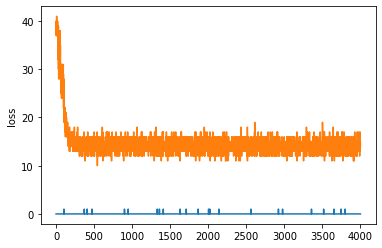

In [ ]:
import matplotlib.pyplot as plt
epoch_lst = []
for i in range(len(d_losses)):
    epoch_lst.append(i)
plt.plot(epoch_lst, d_losses)
plt.plot(epoch_lst, g_losses)

#plt.xlabel('epoch')
plt.ylabel('loss') #각 값에 대한 캡션이라고 보면 됨
plt.show()

#FIlter


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

src = cv2.imread('./result/original.png', cv2.IMREAD_GRAYSCALE)
srcArray = np.array(src)

for i in range(srcArray.shape[0]):
  for j in range(srcArray.shape[-1]):
    if srcArray[i][j] < 100: 
      srcArray[i][j] = 0
    else:
      srcArray[i][j] = 255

pil_image=Image.fromarray(srcArray)
pil_image.save('./result/temp.png')
contrast_img = cv2.cvtColor(srcArray, cv2.COLOR_GRAY2BGR)
cv2_imshow(contrast_img)


In [ ]:
src = cv2.imread('./result/temp.png', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()
    
dst = cv2.medianBlur(src, 7)

cv2_imshow(dst)
img = Image.fromarray(dst)
img.save('./result/after.png')